<a href="https://colab.research.google.com/github/r-kovalch/acter-ner/blob/main/notebooks/acter-cvalue-rerank-annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/r-kovalch/acter-ner

fatal: destination path 'acter-ner' already exists and is not an empty directory.


In [2]:
!git clone https://github.com/lang-uk/extractomat.git

fatal: destination path 'extractomat' already exists and is not an empty directory.


In [3]:
!git clone https://github.com/AylaRT/ACTER

fatal: destination path 'ACTER' already exists and is not an empty directory.


In [4]:
!pip install -q \
  numpy==1.26.4 \
  spacy \
  spacy-layout \
  sentence-transformers \
  gitpython \
  matplotlib \
  tqdm -q

!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 79.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
!ls

ACTER			acter-ner	sample_data
acter_en_gt.csv		dummy_test.tsv	train_full.tsv
acter_en_unlabeled.txt	extractomat	val_full.tsv


In [6]:
import subprocess, sys
from pathlib import Path

# IOB directories inside the cloned ACTER repository
io_dirs = [
    "/content/ACTER/en/corp/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
    "/content/ACTER/en/equi/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
    "/content/ACTER/en/htfl/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
    "/content/ACTER/en/wind/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
]

# Output files (80 % train, 20 % validation, no test set)
train_tsv = Path("train_full.tsv")
val_tsv   = Path("val_full.tsv")     # ← our gold set
# dummy test file because the script requires one
test_tsv  = Path("dummy_test.tsv")

args = [
    "python", "/content/acter-ner/term_extractor/preprocess_acter.py",
    "--input_dirs", *io_dirs,
    "--train_output", str(train_tsv),
    "--test_output",  str(test_tsv),
    "--val_output",   str(val_tsv),
    "--test_size", "0.0",            # no test set – everything goes to val
    "--val_size",  "0.2",            # 20 % of data kept with labels
    "--seed",      "42",
]

print("⏳ Running:", " ".join(args))
subprocess.check_call(args)
print("✓ Splits ready →", train_tsv, "and", val_tsv)


⏳ Running: python /content/acter-ner/term_extractor/preprocess_acter.py --input_dirs /content/ACTER/en/corp/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/ /content/ACTER/en/equi/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/ /content/ACTER/en/htfl/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/ /content/ACTER/en/wind/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/ --train_output train_full.tsv --test_output dummy_test.tsv --val_output val_full.tsv --test_size 0.0 --val_size 0.2 --seed 42
✓ Splits ready → train_full.tsv and val_full.tsv


In [7]:
# Cell 4b – rebuild gold-term list by grouping B/I spans from val_full.tsv

from pathlib import Path
import csv

VAL_TSV = Path("val_full.tsv")
GT_CSV  = Path("acter_en_gt.csv")

terms = set()
current = []

for line in VAL_TSV.read_text(encoding="utf-8").splitlines():
    if not line.strip():
        # sentence break → flush any ongoing term
        if current:
            terms.add(" ".join(current).lower())
            current = []
        continue

    token, label = line.split("\t")
    # labels are like "B-TERM", "I-TERM", or "O"
    if label.startswith("B"):
        # start a new term (flush old one first)
        if current:
            terms.add(" ".join(current).lower())
        current = [token]
    elif label.startswith("I") and current:
        # continuation of the current term
        current.append(token)
    else:
        # outside a term → flush
        if current:
            terms.add(" ".join(current).lower())
            current = []

# catch any trailing term
if current:
    terms.add(" ".join(current).lower())

# write out CSV: one term per line
with GT_CSV.open("w", encoding="utf-8", newline="") as f:
    writer = csv.writer(f)
    for t in sorted(terms):
        writer.writerow([t])

print(f"✓ Rebuilt gold CSV with {len(terms):,} unique terms → {GT_CSV}")


✓ Rebuilt gold CSV with 2,231 unique terms → acter_en_gt.csv


In [8]:
sys.path.insert(0, str(Path.cwd() / "extractomat"))

from pathlib import Path
import spacy
from matcha import cvalue
from tester import TermEvaluator

UNLABELED_TXT = Path("acter_en_unlabeled.txt")      # 80 % raw text
GT_CSV        = Path("acter_en_gt.csv")             # 20 % gold terms

# 1️⃣ Linguistic pre-processing (tokenise, lemmatise) – any spaCy EN model works
nlp = spacy.load("en_core_web_sm", disable=["ner"])
doc = nlp(UNLABELED_TXT.read_text().lower())

# 2️⃣ C-Value scoring (nested n-grams 2…8 tokens, with slight smoothing)
term_scores, term_occ = cvalue(
    doc,
    n_min=2,     # smallest n-gram to consider
    n_max=8,     # longest n-gram
    smoothing=0.1
)

print(f"Extracted {len(term_scores):,} candidate terms")

Extracted 24,801 candidate terms


In [9]:
# Cell 5b – robust threshold sweep for C-Value
import numpy as np
from tester import TermEvaluator

# 1) Instantiate the evaluator once:
evaluator = TermEvaluator(
    "acter_en_gt.csv",    # your 20% GT-term list from Step 4
    term_scores,          # from Cell 5
    term_occ,             # from Cell 5
    method="cvalue",
    language="en"
)

# 2) Build 100 thresholds from just below min(score) up to max(score):
scores = np.array(list(term_scores.values()))
t_min, t_max = scores.min(), scores.max()
thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

best = {"f1": -1.0}

# 3) Sweep, catching any zero-division cases:
for t in thresholds:
    try:
        p, r, f1 = evaluator.calculate_metrics(t)
    except ZeroDivisionError:
        # no candidates or no GT terms at this t → skip
        continue
    if f1 > best["f1"]:
        best.update(threshold=t, precision=p, recall=r, f1=f1)


▶ Best C-Value results (threshold sweep):
   threshold = 7.42822
   precision = 0.317
   recall    = 0.190
   F1        = 0.237


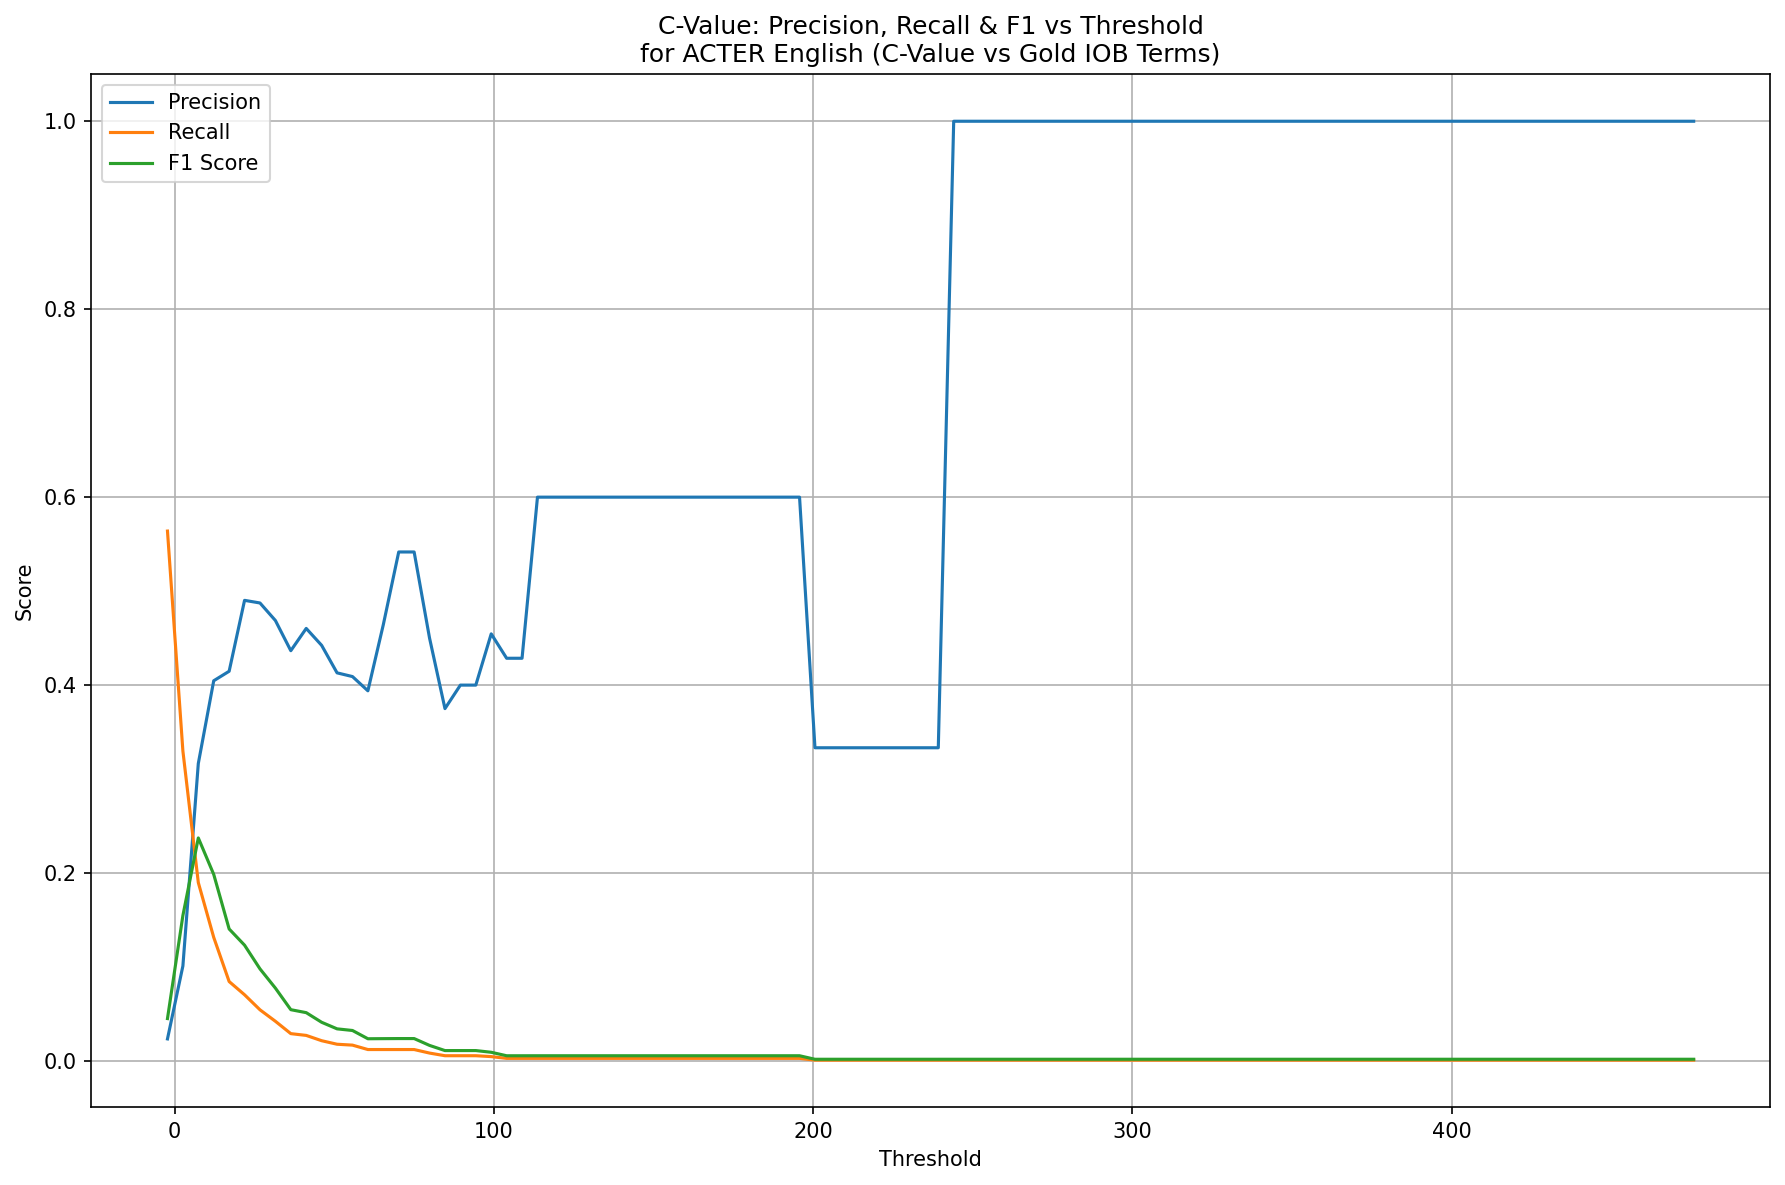

▶ Best C-Value results (threshold sweep):
   threshold = 7.42822
   precision = 0.317
   recall    = 0.190
   F1        = 0.237


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import importlib.util
from pathlib import Path

# ── dynamically load tester.py from extractomat ────────────────────────────
extractomat_dir = Path.cwd() / "extractomat"
tester_file = extractomat_dir / "tester.py"
spec = importlib.util.spec_from_file_location("tester", str(tester_file))
tester = importlib.util.module_from_spec(spec)
spec.loader.exec_module(tester)
TermEvaluator = tester.TermEvaluator

# ── evaluator setup ───────────────────────────────────────────────────────
evaluator = TermEvaluator(
    "acter_en_gt.csv",   # Gold-standard terms from IOB validation
    term_scores,         # your C-Value scores
    term_occ,            # your occurrence dict
    method="cvalue",
    language="en"
)

# ── threshold sweep ────────────────────────────────────────────────────────
scores = np.array(list(term_scores.values()))
t_min, t_max = scores.min(), scores.max()
thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

precisions, recalls, f1_scores = [], [], []
for t in thresholds:
    try:
        p, r, f1 = evaluator.calculate_metrics(t)
    except ZeroDivisionError:
        p = r = f1 = 0.0
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)

# ── plotting ──────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls,    label="Recall")
plt.plot(thresholds, f1_scores,  label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("C-Value: Precision, Recall & F1 vs Threshold\nfor ACTER English (C-Value vs Gold IOB Terms)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("▶ Best C-Value results (threshold sweep):")
print(f"   threshold = {best['threshold']:.5f}")
print(f"   precision = {best['precision']:.3f}")
print(f"   recall    = {best['recall']:.3f}")
print(f"   F1        = {best['f1']:.3f}")



In [ ]:
import sys, os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ── ensure extractomat is importable ───────────────────────────────────────
sys.path.insert(0, os.path.join(os.getcwd(), "extractomat"))
from sbert_reranker import SentenceSimilarityCalculator

# ── load torch & SBERT (GPU if available) ─────────────────────────────────
import torch
from sentence_transformers import SentenceTransformer  # imported for completeness

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🔧 SBERT device → {device}")

# ── instantiate the reranker correctly ────────────────────────────────────
reranker = SentenceSimilarityCalculator(
    model_name="sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
    device=device
)

# ── re-rank your C-Value candidates ───────────────────────────────────────
reranked_scores = reranker.rerank_terms_in_doc(
    doc,             # spaCy Doc from C-Value step
    term_occ,        # occurrences dict from C-Value step
    context_len=3,
    pooling="max"
)
print(f"✅ Re-ranked {len(reranked_scores):,} terms")

# ── rebuild gold terms from IOB validation split (val_full.tsv) ──────────
val_tsv = Path("val_full.tsv")
gold_terms = set()
current = []

for line in val_tsv.read_text(encoding="utf-8").splitlines():
    if not line.strip():
        if current:
            gold_terms.add(" ".join(current).lower())
            current = []
        continue
    token, label = line.split("\t")
    if label.startswith("B"):
        if current:
            gold_terms.add(" ".join(current).lower())
        current = [token]
    elif label.startswith("I") and current:
        current.append(token)
    else:
        if current:
            gold_terms.add(" ".join(current).lower())
            current = []
if current:
    gold_terms.add(" ".join(current).lower())

print(f"🎯 Loaded {len(gold_terms):,} gold terms")

🔧 SBERT device → cpu


In [ ]:
scores = np.array(list(reranked_scores.values()))
t_min, t_max = scores.min(), scores.max()
thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

precisions, recalls, f1_scores = [], [], []
for t in thresholds:
    preds = {term for term, sc in reranked_scores.items() if sc >= t}
    tp = len(preds & gold_terms)
    p = tp / len(preds) if preds else 0.0
    r = tp / len(gold_terms) if gold_terms else 0.0
    f1 = (2 * p * r / (p + r)) if (p + r) > 0 else 0.0
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)

# ── plot Precision, Recall & F1 vs Threshold ─────────────────────────────
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls,    label="Recall")
plt.plot(thresholds, f1_scores,  label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title(
    "SBERT ReRank: Precision, Recall & F1 vs Threshold\n"
    "for ACTER English (ReRank vs Gold IOB Terms)"
)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()